# Example: Evaluate Segmentation Models on SynthMT

**Note**: Before running this notebook, ensure you have installed the necessary dependencies as described in the [Installation section of the README](https://github.com/ml-lab-htw/SynthMT#installation). Running this notebook takes ~10 min.

This notebook demonstrates how to:
1. Load the SynthMT dataset from HuggingFace
2. Load a segmentation model using the ModelFactory
3. Run predictions on the dataset (with proper preprocessing)
4. Evaluate performance using segmentation and downstream metrics

## Available Models

The following models are available through the ModelFactory:
- **FIESTA** - Classical filament tracking algorithm (outputs anchor points, needs MATLAB installation)
- **StarDist** - Star-convex polygon detection
- **TARDIS** - Transformer-based detection (outputs anchor points)
- **µSAM** - Microscopy-specific SAM (requires conda installation)
- **CellSAM** - Cell-specific SAM variant
- **CellposeSAM** - Cellpose combined with SAM
- **SAM, SAM2, SAM3, SAM3Text** - Segment Anything Model variants

In [2]:
import os

# Fix for "OMP: Error #15: Initializing libomp.dylib, but found libomp.dylib already initialized."
# This often happens on macOS when multiple libraries link against OpenMP.
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import json

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from synth_mt.utils.preprocessing import get_preprocess_params, sample_to_arrays
from synth_mt.benchmark.metrics import calculate_segmentation_metrics, calculate_downstream_metrics
from synth_mt.benchmark.models.anchor_point_model import AnchorPointModel
from synth_mt.benchmark.models.factory import setup_model_factory
from synth_mt.utils import preprocessing as pre
from synth_mt.utils import postprocessing as post
from synth_mt.plotting import create_overlay

# Load potential CellSAM token from .env file
from dotenv import load_dotenv

from datasets import load_dataset

load_dotenv()

True

## Load SynthMT Dataset

We load the dataset from HuggingFace and limit to the first 100 images for faster evaluation.


In [3]:
NUM_SAMPLES = 10

ds = load_dataset("HTW-KI-Werkstatt/SynthMT", split="train")
ds = ds.select(range(min(NUM_SAMPLES, len(ds))))

print(f"Loaded {len(ds)} samples for evaluation.")

Loaded 10 samples for evaluation.


## Setup Model Factory and Load Model

The ModelFactory provides a unified interface to load any of the available segmentation models.


In [4]:
factory = setup_model_factory()

print("Available models:")
for model_name in factory.get_available_models():
    print(f"  - {model_name}")

# NOTE: This cell might throw some errors and warnings, depending on which models you have (not) installed.

Matlab engine not available


Available models:
  - cellposesam
  - cellsam
  - fiesta
  - microsam
  - sam
  - sam2
  - sam3
  - sam3text
  - stardist
  - tardis


objc[82323]: Class QT_ROOT_LEVEL_POOL__THESE_OBJECTS_WILL_BE_RELEASED_WHEN_QAPP_GOES_OUT_OF_SCOPE is implemented in both /Users/jw/miniforge3/envs/synth_mt_test/lib/libQt6Core.6.10.1.dylib (0x31ba1d5e0) and /Users/jw/miniforge3/envs/synth_mt_test/lib/libQt5Core.5.15.15.dylib (0x431b712f8). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[82323]: Class KeyValueObserver is implemented in both /Users/jw/miniforge3/envs/synth_mt_test/lib/libQt6Core.6.10.1.dylib (0x31ba1d608) and /Users/jw/miniforge3/envs/synth_mt_test/lib/libQt5Core.5.15.15.dylib (0x431b71320). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[82323]: Class RunLoopModeTracker is implemented in both /Users/jw/miniforge3/envs/synth_mt_test/lib/libQt6Core.6.10.1.dylib (0x31ba1d658) and /Users/jw/miniforge3/envs/synth_mt_test/lib/libQt5Core.5.15.15.dylib (0x431b71370). This may cause spur

In [5]:
MODEL_NAME = "cellposesam"
# MODEL_NAME = "cellsam"
# MODEL_NAME = "fiesta"  # Mario TODO: test!
# MODEL_NAME = "microsam"
# MODEL_NAME = "sam"
# MODEL_NAME = "sam2"
# MODEL_NAME = "sam3"  # NOTE: Need to run pip install -U transfomers -pre
# MODEL_NAME = "sam3text"  # NOTE: Need to run pip install -U transfomers -pre
# MODEL_NAME = "stardist"
# MODEL_NAME = "tardis"

use_hpo_params = True

if use_hpo_params:
    config_path = f"../synth_mt/benchmark/models/{MODEL_NAME}_hpo.json"
else:
    config_path = f"../synth_mt/benchmark/models/{MODEL_NAME}_default.json"

if os.path.exists(config_path):
    with open(config_path, "r") as f:
        model_config_params = json.load(f)
else:
    model_config_params = {}
    print(f"Warning: Config file '{config_path}' not found. Using default parameters.")

model = factory.create_model(MODEL_NAME, **model_config_params)
model.load_model()

print(f"Loaded model: {model}")
print(f"Model type: {'AnchorPointModel' if isinstance(model, AnchorPointModel) else 'MaskModel'}")

print(f"Model configuration from '{config_path}':")
print("Model configuration parameters:")
for key, value in model_config_params.items():
    print(f"  - {key}: {value}")

Loaded model: Cellpose-SAM
Model type: MaskModel
Model configuration from '../synth_mt/benchmark/models/cellposesam_hpo.json':
Model configuration parameters:
  - model_name: Cellpose-SAM
  - grayscale: True
  - sharpen_radius: 1.4542666093583856
  - smooth_radius: 19.79179006976966
  - percentile_min: 2.008779890024262
  - percentile_max: 99.42081064089238
  - clip_to_percentiles: False
  - rescale_using_percentiles: True
  - invert: True
  - histogram_normalization: False
  - cellprob_threshold: 0.3724210029026884
  - diameter: 37
  - flow_threshold: 0.832387064208597


## Run Predictions

Iterate over the dataset and collect predictions and ground truth masks.

**Note:** Some models (FIESTA, TARDIS) output anchor points instead of masks. The metrics functions handle both formats.


In [6]:
preprocess_params = get_preprocess_params(model)

all_gt_masks = []
all_pred_masks = []
all_images = []
all_processed_images = []

is_anchor_point_model = isinstance(model, AnchorPointModel)

for sample in tqdm(ds, desc=f"Collecting Data for {MODEL_NAME}"):
    image, gt_masks = sample_to_arrays(sample)
    processed_image = pre.process_image(image, **preprocess_params)

    all_images.append(image)
    all_processed_images.append(processed_image)
    all_gt_masks.append(gt_masks)

In [7]:
all_pred_masks = model.predict_batch(all_processed_images)
print(f"Completed predictions on {len(all_images)} images.")

Completed predictions on 10 images.


# Postprocessing

Filter out small and large instances by area and length.


In [8]:
# These values are used to filter out small and large instances.
# We calculated these values from our released SynthMT dataset available at https://huggingface.co/datasets/HTW-KI-Werkstatt/SynthMT
postprocessing_props = {
    "min_area": 12.0,
    "max_area": 1525.0,
    "min_length": 1.0,
    "max_length": 314.0,
    "border_margin": -1,
    "image_resolution": all_images[0].shape[:2],
}

if is_anchor_point_model:
    all_pred_masks = [
        post.filter_anchor_points(mask, **postprocessing_props) for mask in all_pred_masks
    ]
else:
    all_pred_masks = [
        post.filter_instance_masks(mask, **postprocessing_props) for mask in all_pred_masks
    ]

## Visualize Sample Predictions

Compare ground truth and predicted segmentations on a few examples.

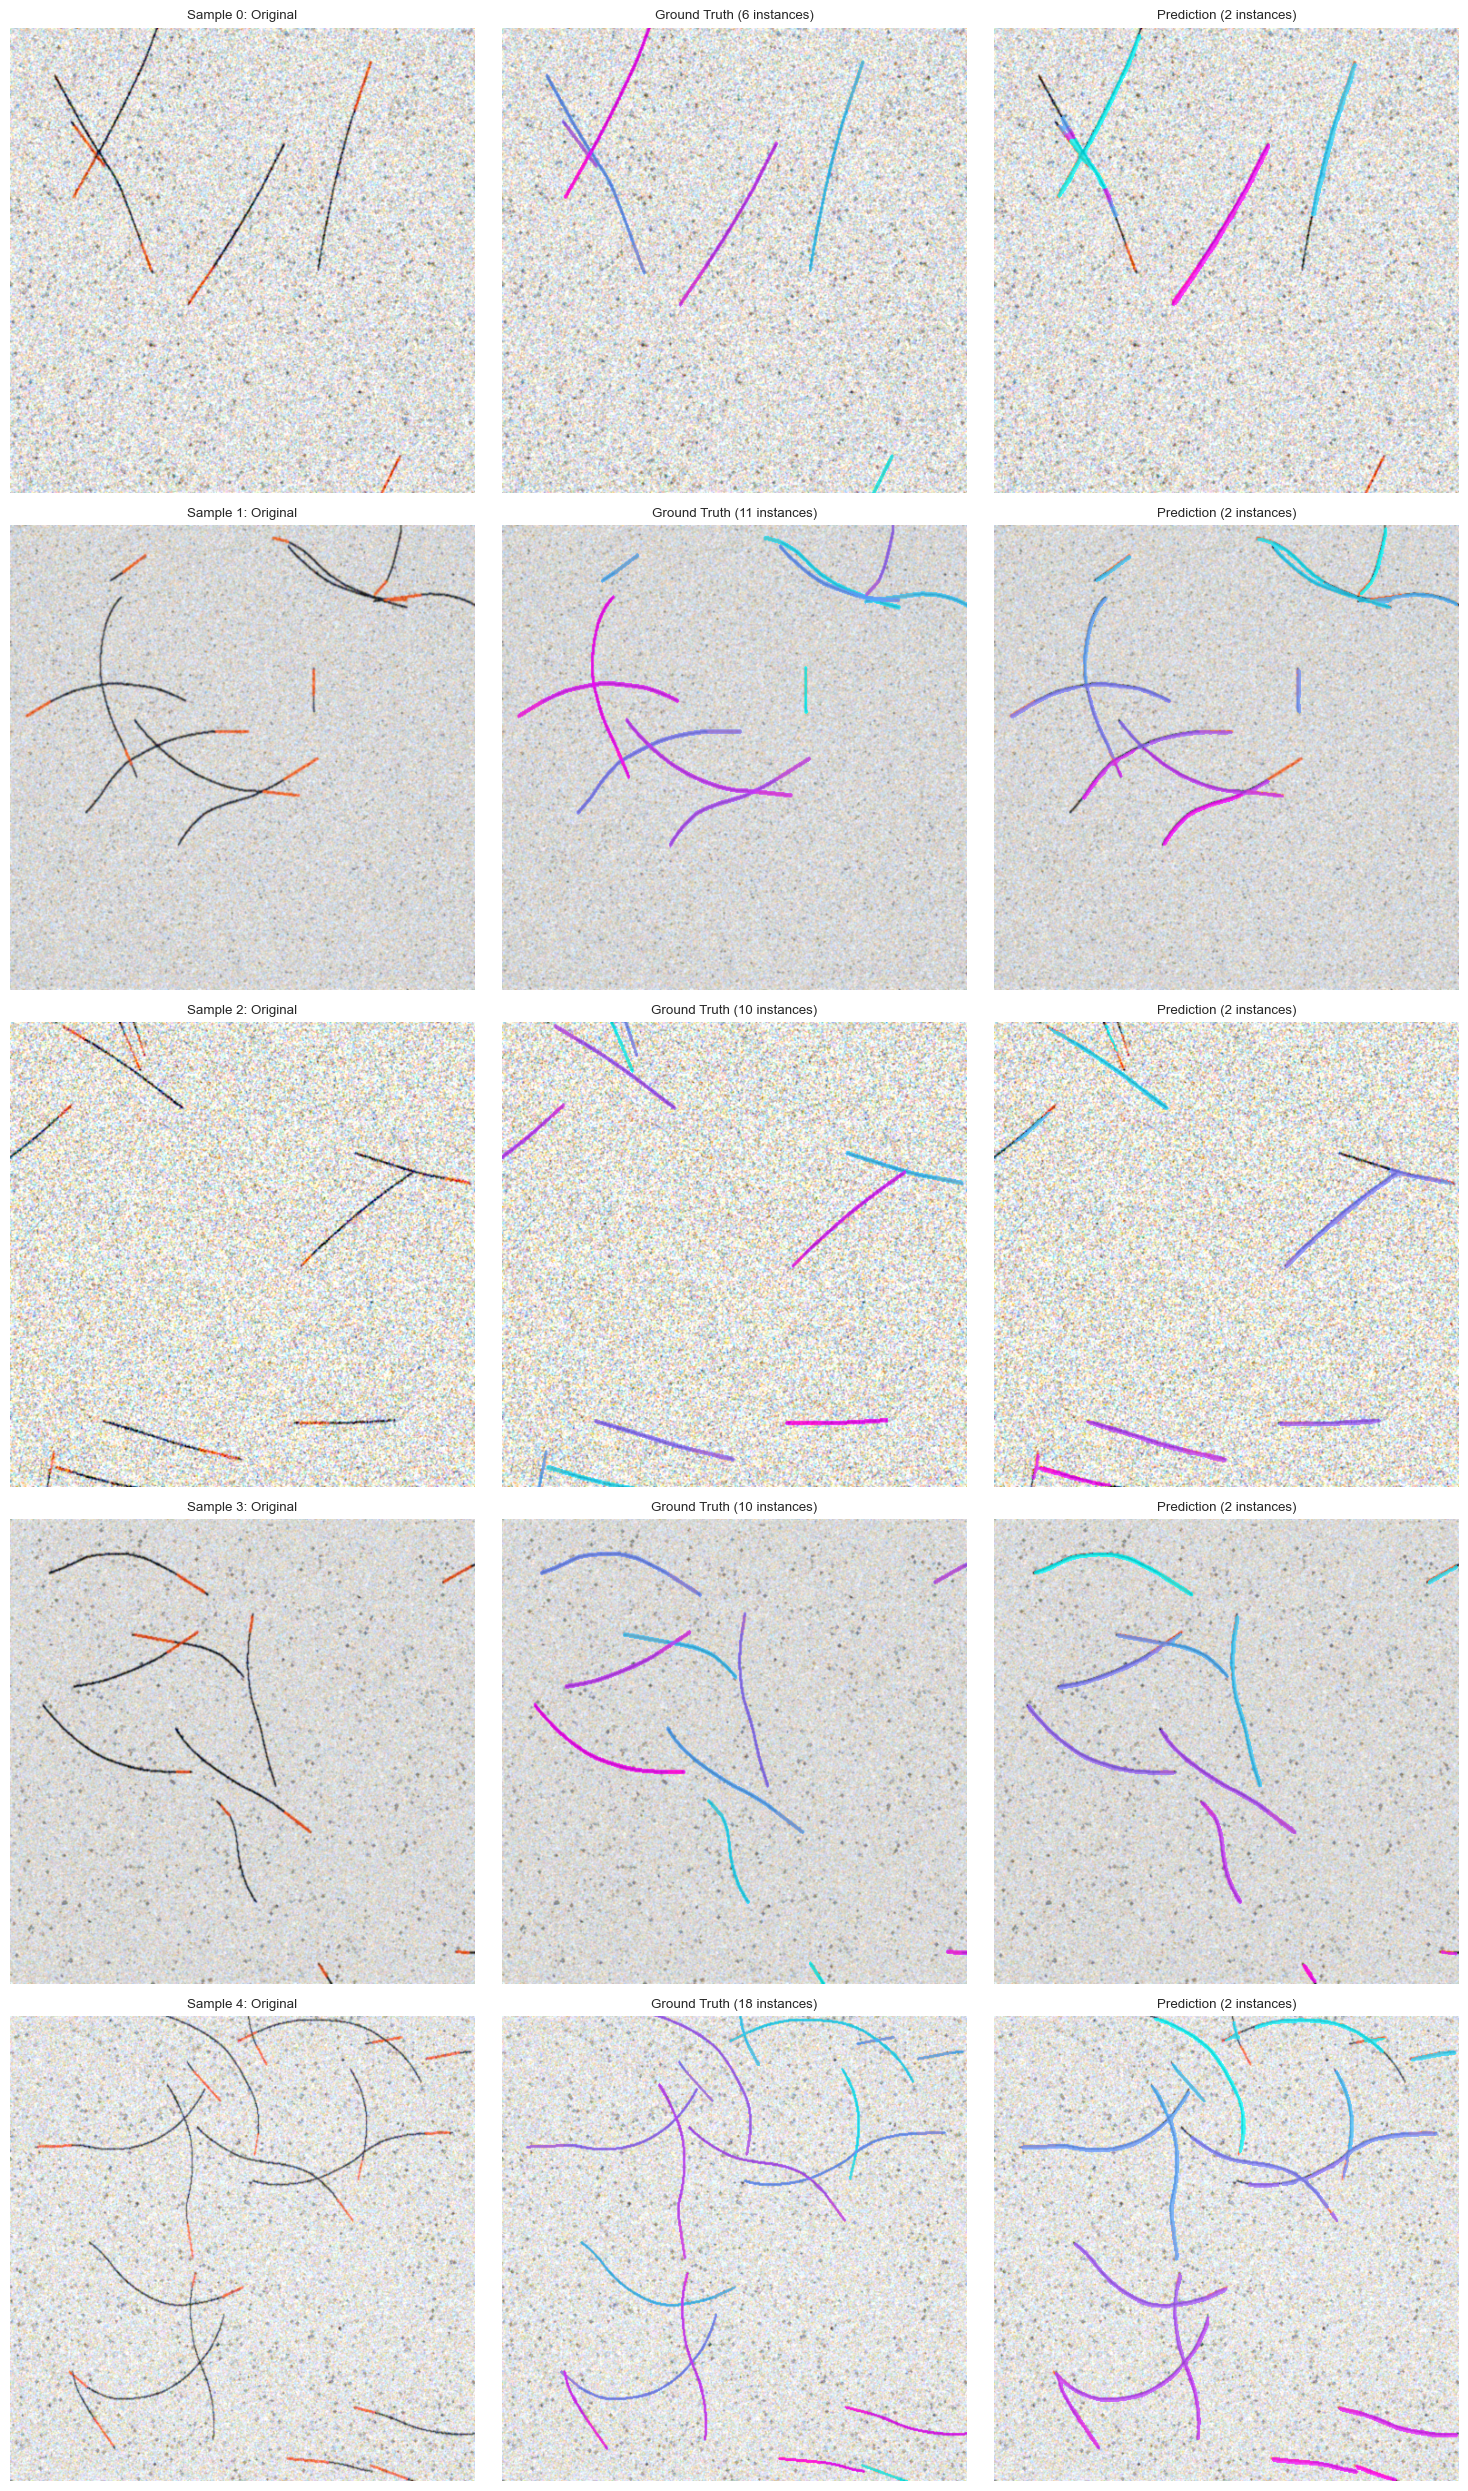

In [9]:
%matplotlib inline

n_samples = min(5, len(all_images))
fig, axs = plt.subplots(n_samples, 3, figsize=(15, 5 * n_samples))

for sample_idx in range(n_samples):
    gt_overlay = create_overlay(all_images[sample_idx], all_gt_masks[sample_idx])
    pred_overlay = create_overlay(all_images[sample_idx], all_pred_masks[sample_idx])

    if is_anchor_point_model:
        num_instances = len(all_pred_masks[sample_idx])
    else:
        num_instances = len(np.unique(all_pred_masks[sample_idx]))

    axs[sample_idx, 0].imshow(all_images[sample_idx])
    axs[sample_idx, 0].set_title(f"Sample {sample_idx}: Original")

    axs[sample_idx, 1].imshow(gt_overlay)
    axs[sample_idx, 1].set_title(f"Ground Truth ({all_gt_masks[sample_idx].shape[0]} instances)")

    axs[sample_idx, 2].imshow(pred_overlay)
    axs[sample_idx, 2].set_title(f"Prediction ({num_instances} instances)")

    axs[sample_idx, 0].axis("off")
    axs[sample_idx, 1].axis("off")
    axs[sample_idx, 2].axis("off")

plt.tight_layout()
plt.show()

## Calculate Segmentation Metrics

Compute instance segmentation metrics including:
- **Precision, Recall, F1** at various IoU thresholds
- **Skeletonized IoU (SkIoU)** - IoU computed on skeletonized masks, better suited for filamentous structures

In [10]:
mean_metrics, std_metrics = calculate_segmentation_metrics(
    gt_masks=all_gt_masks,
    pred_masks=None if is_anchor_point_model else all_pred_masks,
    anchor_points_instance_masks=all_pred_masks if is_anchor_point_model else None,
    use_skeletonized_version=True,
)

print(f"\n{'='*60}")
print(f"Segmentation Metrics for {MODEL_NAME}")
print(f"{'='*60}")
print(f"{'Metric':<30} {'Mean':>12}")
print(f"{'-'*60}")

for key in ["SKIoU_mean", "F1@0.50", "F1@0.75"]:
    if key in mean_metrics:
        print(f"{key:<30} {mean_metrics[key]:>12.4f}")


Segmentation Metrics for cellposesam
Metric                                 Mean
------------------------------------------------------------
SKIoU_mean                           0.7343
F1@0.50                              0.8347
F1@0.75                              0.7170


## Calculate Downstream Metrics

Compute biologically relevant downstream metrics:
- **Count Error** - Difference in number of detected microtubules
- **Length Distribution** - KL divergence between predicted and ground truth length distributions
- **Curvature Distribution** - KL divergence between predicted and ground truth curvature distributions


In [11]:
downstream_metrics = calculate_downstream_metrics(
    gt_masks=all_gt_masks,
    pred_masks=None if is_anchor_point_model else all_pred_masks,
    anchor_points_instance_masks=all_pred_masks if is_anchor_point_model else None,
    pixel_per_micrometer=9.0,
)

print(f"\n{'='*60}")
print(f"Downstream Metrics for {MODEL_NAME}")
print(f"{'='*60}")
print(f"{'Metric':<40} {'Value':>15}")
print(f"{'-'*60}")
for key in [
    "Avg Count GT",
    "Avg Count Pred",
    "Avg Length GT (um)",
    "Avg Length Pred (um)",
    "Length_KL",
    "Avg Curvature GT (1/um)",
    "Avg Curvature Pred (1/um)",
    "Curvature_KL",
]:
    print(f"{key:<40} {downstream_metrics[key]:>15.2f}")


Downstream Metrics for cellposesam
Metric                                             Value
------------------------------------------------------------
Avg Count GT                                       12.40
Avg Count Pred                                     13.60
Avg Length GT (um)                                 13.02
Avg Length Pred (um)                               10.48
Length_KL                                           0.16
Avg Curvature GT (1/um)                             8.76
Avg Curvature Pred (1/um)                           8.86
Curvature_KL                                        0.14
